In [1]:
from PIL import Image
import os
import numpy as np
import tqdm.notebook as tqdm
import torch

In [2]:
PATH = "/home/yperron/code/archaeo_segment/datasets/Gleason"

folder_list = ["Maps1_T", "Maps2_T", "Maps3_T", "Maps4_T", "Maps5_T", "Maps5_T"]

folder_list = [f"{PATH}/{folder}" for folder in folder_list]

#verify all folders are present
for folder in folder_list:
    if not os.path.exists(folder) and os.path.isdir(folder):
        print(f"Folder not found: {folder}")
    else:
        print(f"Folder exists: {folder}")

# create output directory
output_dir = os.path.join(PATH, "Maps_majority")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps1_T
Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps2_T
Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps3_T
Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps4_T
Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps5_T
Folder exists: /home/yperron/code/archaeo_segment/datasets/Gleason/Maps5_T


In [3]:
# Get all files in at least one folder
files_set = set()

for folder in folder_list:
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if os.path.isfile(file_path):
            files_set.add(file)

In [4]:
# Create a dictionary mapping each file to a list of all its locations across the folders
locations_dict = {}

for file in files_set:
    locations = []
    for folder in folder_list:
        candidate_path = os.path.join(folder, file)
        if os.path.isfile(candidate_path):
            locations.append(candidate_path)
    locations_dict[file] = locations

# Print mean number of locations per file
locations_per_file = [len(locations) for locations in locations_dict.values()]
print(f"Mean number of locations per file: {np.mean(locations_per_file)}")

Mean number of locations per file: 5.518218623481781


In [7]:
for file, paths in tqdm.tqdm(locations_dict.items()):
    images = []
    for img_path in paths:
        # open and convert to numpy array
        img_arr = np.array(Image.open(img_path))
        images.append(img_arr)

    images_stack = torch.from_numpy(np.stack(images, axis=0))


    # Check if the image is grayscale or color
    if images_stack.ndim == 3:
        # Grayscale: shape (n, h, w)
        mode_img = torch.mode(images_stack, dim=0).values.numpy()
    else:
        print(f"Unexpected image dimensions for file: {file}")
        continue

    out_path = os.path.join(output_dir, file)
    Image.fromarray(mode_img).save(out_path)
    print(f"Saved mode image for {file} to {out_path}")

  0%|          | 0/247 [00:00<?, ?it/s]

Saved mode image for slide001_core112_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide001_core112_classimg_nonconvex.png
Saved mode image for slide002_core145_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide002_core145_classimg_nonconvex.png
Saved mode image for slide003_core108_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide003_core108_classimg_nonconvex.png
Saved mode image for slide002_core033_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide002_core033_classimg_nonconvex.png
Saved mode image for slide005_core104_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide005_core104_classimg_nonconvex.png
Saved mode image for slide005_core097_classimg_nonconvex.png to /home/yperron/code/archaeo_segment/datasets/Gleason/Maps_majority/slide005_core097_cla

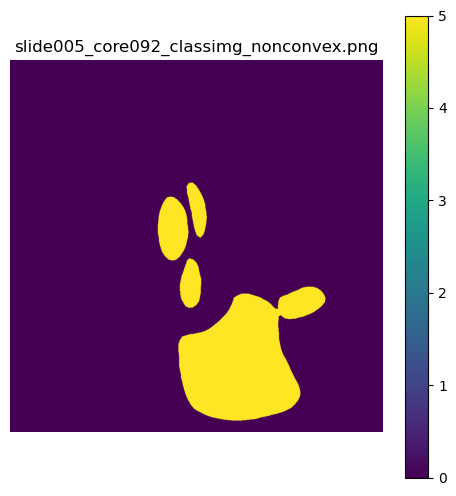

In [ ]:
import random

import matplotlib.pyplot as plt

# Pick a random file from the locations_dict keys
rand_file = random.choice(list(locations_dict.keys()))
# Get one image path (first occurrence) for the selected file
rand_path = locations_dict[rand_file][0]

# Open the image and display it
img = Image.open(rand_path)
plt.figure(figsize=(6,6))
im = plt.imshow(img)
plt.axis("off")
plt.title(rand_file)
plt.colorbar(im)
plt.show()

In [26]:
id_to_trainid = {1: 0, 2: 0, 6: 0, 3: 1, 4: 2, 5: 3}
inverted_mapping = {
    v: k for k, v in id_to_trainid.items() if v != 255 and v != 0
}
print(inverted_mapping)
n = 100
nb_classes = 8
array = np.zeros((nb_classes))
array_no_map = np.zeros((nb_classes))
array_reverse = np.zeros((nb_classes))
#open n file and save the number of pixel of each class in the array
for i in range(n):
    rand_file = random.choice(list(locations_dict.keys()))
    rand_path = locations_dict[rand_file][0]
    img = Image.open(rand_path)
    img_arr = np.array(img)

    for j in range(nb_classes):
        array_no_map[j] += np.sum(img_arr == j)

    for k,v in id_to_trainid.items():
        img_arr[img_arr == k] = v

    for j in range(nb_classes):
        array[j] += np.sum(img_arr == j)

    new_array = img_arr.copy()
    for k, v in inverted_mapping.items():
        new_array[img_arr == k] = v
    img_arr = new_array

    for j in range(nb_classes):
        array_reverse[j] += np.sum(img_arr == j)

print(array_no_map)
print(array)
print(array_reverse)

{1: 3, 2: 4, 3: 5}
[1.32375424e+09 2.82237680e+07 0.00000000e+00 2.59638273e+08
 7.84061404e+08 8.74691020e+07 8.90101360e+07 0.00000000e+00]
[1.44098815e+09 2.59638273e+08 7.84061404e+08 8.74691020e+07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[1.44098815e+09 0.00000000e+00 0.00000000e+00 2.59638273e+08
 7.84061404e+08 8.74691020e+07 0.00000000e+00 0.00000000e+00]
